In [1]:
import sys
import os
from dotenv import load_dotenv
load_dotenv()
pyAPES_main_folder = os.getenv('pyAPES_main_folder')
sys.path.append(pyAPES_main_folder)

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D

import numpy as np
from pyAPES.utils.iotools import read_forcing
from pyAPES.soil.soil import Soil_1D
from pyAPES.canopy.forestfloor import ForestFloor
from pyAPES.parameters.Degero import gpara, cpara, spara # model configuration, canopy parameters, soil parameters
from pyAPES.utils.constants import WATER_DENSITY
%matplotlib widget

In [2]:
# Creating ForestFloor
snowmod = 'degreeday'
cpara['forestfloor']['snowpack']['snow_model'] = snowmod # 'fsm2' or 'degreeday'

forestfloor = ForestFloor(cpara['forestfloor'])

# Creating Soil_1D
soil = Soil_1D(spara)

# Manipulating the params to correspond to those of Degerö
gpara['forc_filename'] = f'{pyAPES_main_folder}/forcing/Degero/Degero_forcing_2021-2023.dat'
gpara['start_time'] = '2021-09-01'
gpara['end_time'] = '2023-07-01'


In [3]:
# Reading the forcing file
forcing = read_forcing(
    forcing_file=gpara['forc_filename'],
    start_time=gpara['start_time'],
    end_time=gpara['end_time'],
    dt=gpara['dt']
)

In [4]:
threshold = 2.0
sfcf_2022 = 1.5
sfcf_2023 = 1.6
cutoff = pd.Timestamp('2022-09-01')
linear = True

T = forcing['Tair']
P = forcing['Prec']

if linear:
    # Define conditions
    conditions = [
        T <= 0,                          # below freezing
        (T > 0) & (T < threshold),       # between 0 and threshold
        T >= threshold                   # above threshold
    ]
    # Define corresponding liquid fractions
    fractions = [
        0.0,                             # all ice
        T / threshold,                   # linear transition
        1.0                              # all liquid
    ]

    # Compute fraction of liquid
    frac_liquid = np.select(conditions, fractions)
else:
    frac_liquid = np.where(T >= threshold, 1.0, 0.0)

dates = forcing.index
# Build conditional array
sfcf = np.where(dates < cutoff, sfcf_2022, sfcf_2023)

# Apply directly to DataFrame
forcing['Prec_liquid'] = P * frac_liquid
forcing['Prec_ice'] = P * (1 - frac_liquid)
forcing['Prec_ice'] *= sfcf

In [5]:
# Looping over the forcing file, running forestfloor and soil models for each timestep and saving the results
results_df = pd.DataFrame()

# Number of soil layers
n_layers = len(soil.heat.T)  # or len(s_states['temperature']) at first timestep
# Number of timesteps
n_times = len(forcing)

for index, row in forcing.iterrows():

    ###### Inputs for forestfloor (based on how they are used in mlm_canopy.py)
    ff_forcing = {  # Reset the dictionary for each iteration
        'precipitation_rain': row['Prec_liquid'], # kg m-2 s-1
        'precipitation_snow': row['Prec_ice'], # kg m-2 s-1
        'wind_speed': row['U'], # m/s
        'par': row['diffPar'] + row['dirPar'],  # Total PAR [W m-2]
        'nir': row['diffNir'] + row['dirNir'],  # Total NIR [W m-2]
        'lw_dn': row['LWin'],  # Longwave downward radiation [W m-2]
        'h2o': row['H2O'] / 1000,  # H2O [mol mol-1]
        'co2': row['CO2'] * 1e6,  # Convert mol mol-1 to ppm
        'air_temperature': row['Tair'],  # Air temperature [degC]
        'air_pressure': row['P'],  # Air pressure [Pa]
        'relative_humidity': row['RH'], # Relative humidity [%]
        'soil_temperature': soil.heat.T[0], # Soil temperature [degC]
        'soil_water_potential': soil.water.h[0],
        'soil_volumetric_water': soil.heat.Wliq[0],
        'soil_volumetric_air': soil.heat.Wair[0],
        'soil_pond_storage': soil.water.h_pond
    }
    ff_params = {
        'soil_thermal_conductivity': soil.heat.thermal_conductivity[0],
        'soil_hydraulic_conductivity': soil.water.Kvsat[0],
        'soil_depth': soil.grid['dz'][0],
        'reference_height': 3.0,
    }
    ff_controls = {
        'energy_balance': True,
        'logger_info': 'test',
    }
    # --- solve forestfloor
    ff_fluxes, ff_states, gt_results = forestfloor.run(
                dt=gpara['dt'],
                forcing=ff_forcing,
                parameters=ff_params,
                controls=ff_controls
                )
    
    # --- update forestfloor
    forestfloor.update()

    ###### Inputs for soil (based on how they are used in pyAPES_MLM.py)
    s_forcing = {
        'potential_infiltration': ff_fluxes['throughfall'] / WATER_DENSITY,
        'potential_evaporation': (ff_fluxes['soil_evaporation'] + ff_fluxes['capillary_rise']) / WATER_DENSITY,
        'pond_recharge': ff_fluxes['pond_recharge'] / WATER_DENSITY,
        'atmospheric_pressure_head': -1.0E6, # [m]
        'ground_heat_flux': -ff_fluxes['ground_heat'],
        'date': index
    }
    
    s_fluxes, s_states = soil.run(
                dt=gpara['dt'],
                forcing=s_forcing,
                )
    
    # --- update soil
    s_states.update(s_fluxes)
    
    # Combine results into a single dictionary with all values as floats
    combined_results = {
        'time': index,  # Use the time index from the forcing DataFrame
        **{f'gt_{key}': value[0] for key, value in gt_results.items()}, 
        **{f'ff_{key}': value for key, value in ff_states.items()},
        **{f'ff_{key}': value for key, value in ff_fluxes.items()},
        **{f'soil_{key}': value.mean() if hasattr(value, 'mean') else value for key, value in s_states.items()},
        'soil_temperature_0': s_states['temperature'][0],  # top layer only
        'soil_temperature_-1': s_states['temperature'][soil.Nlayers-1]  # bottom layer only
    }

    # Append the combined results to the results DataFrame
    results_df = pd.concat([results_df, pd.DataFrame([combined_results])], ignore_index=True)

results_df.set_index('time', inplace=True)

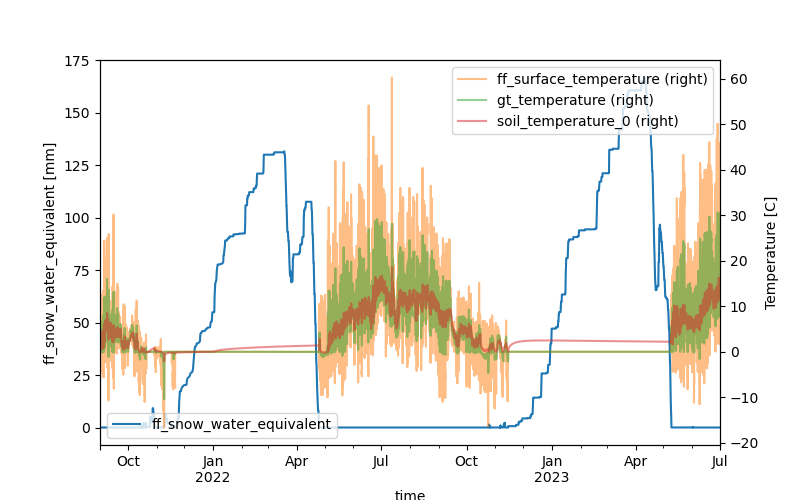

In [6]:
ax = results_df[[#'ff_snow_depth', 
            'ff_snow_water_equivalent'
            ]].plot(figsize=(8, 5))

ax1 = results_df[['ff_surface_temperature',
                 'gt_temperature',
                 'soil_temperature_0']].plot(ax=ax, alpha=0.5, secondary_y=True)

ax.legend(loc='lower left')
ax1.legend(loc='upper right')
ax.set_ylabel('ff_snow_water_equivalent [mm]')
ax1.set_ylabel('Temperature [C]')
#ax.set_ylim([0,150])
#ax1.set_ylim([-50,50])
filename = f'/Users/jpnousu/Library/CloudStorage/OneDrive-Luonnonvarakeskus/pyAPES_figs/stability_{snowmod}_2_2026.png'
plt.savefig(filename, dpi=300, bbox_inches="tight")

In [7]:
met = f'{pyAPES_main_folder}/forcing/Degero/Degero_meteo_2021-2023.dat'
meteo = pd.read_csv(met, sep=';', index_col=0, parse_dates=True)
meteo = meteo[forcing.index[0]: forcing.index[-1]]
meteo['WTD_c'] = meteo['WTD']
meteo.loc[meteo['WTD_c'] < 0, 'WTD_c'] = 0.0
meteo['D_SNOW'] = meteo['D_SNOW']/100
meteo.loc[meteo['D_SNOW'] > 1., 'D_SNOW'] = np.nan
meteo = meteo.resample('D').mean()

binned = pd.cut(meteo['D_SNOW'], bins=100)
most_frequent_bin = binned.value_counts().idxmax()
baseval1 = round((most_frequent_bin.left + most_frequent_bin.right) / 2, 2)
baseval2 = round(meteo['D_SNOW'].median(), 2)
baseval2 = 0.05

meteo['D_SNOW_C'] = meteo['D_SNOW'] - baseval2
meteo.loc[meteo['D_SNOW_C'] < 0., 'D_SNOW_C'] = 0.

In [8]:
if snowmod == 'fsm2':
    plt.figure(figsize=(10, 5))
    ax = plt.gca()
    modstring = f'modeled (T_treshold={threshold}, mixed={linear}, SFCF={sfcf})'
    obsstring = f'observed (z0={baseval2})'
    results_df['ff_snow_depth'].plot(ax=ax, label=modstring)
    #(meteo['D_SNOW'] - meteo['WTD_c']).plot(label='obs (wtd corrected)')
    meteo['D_SNOW_C'].plot(ax=ax, label=obsstring)
    #meteo['WTD'].plot(ax=ax)
    ax2 = ax.twinx()
    forcing['Tair'].resample('D').mean().plot(ax=ax2, alpha=0.2, color='tab:red', label='Tair')
    (forcing['U'].resample('D').mean()).plot(ax=ax2, alpha=0.2, color='grey', label='Wind')
    #meteo['WTD'].plot(alpha=0.5, label='wtd')
    ax.set_ylabel('Snow depth [m]')
    #ax.set_ylim([0,0.6])
    ax2.set_ylabel('Tair [C] & Wind [ms-1]')
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    filename = f'/Users/jpnousu/Library/CloudStorage/OneDrive-Luonnonvarakeskus/pyAPES_figs/hs_{snowmod}_2_2026.png'
    plt.savefig(filename, dpi=300, bbox_inches="tight")

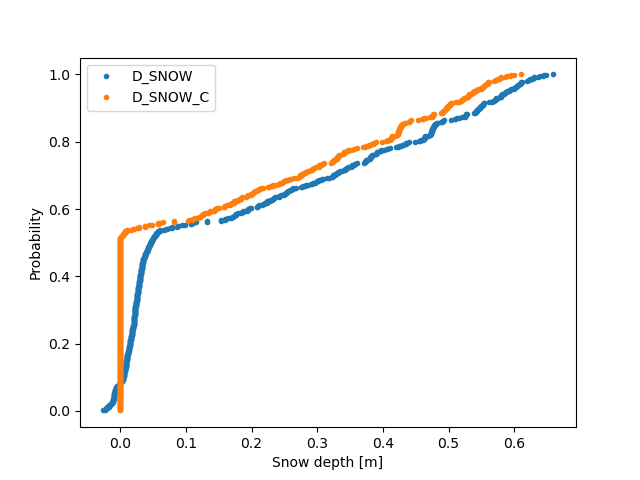

In [9]:
data = meteo['D_SNOW'].dropna().sort_values()
data2 = meteo['D_SNOW_C'].dropna().sort_values()

# Compute EDF values
edf = np.arange(1, len(data) + 1) / len(data)
edf2 = np.arange(1, len(data2) + 1) / len(data)

# Plot
plt.figure()
plt.plot(data, edf, marker='.', linestyle='none', color='tab:blue', label='D_SNOW')
plt.plot(data2, edf2, marker='.', linestyle='none', color='tab:orange', label='D_SNOW_C')
plt.ylabel('Probability')
plt.xlabel('Snow depth [m]')
plt.legend()

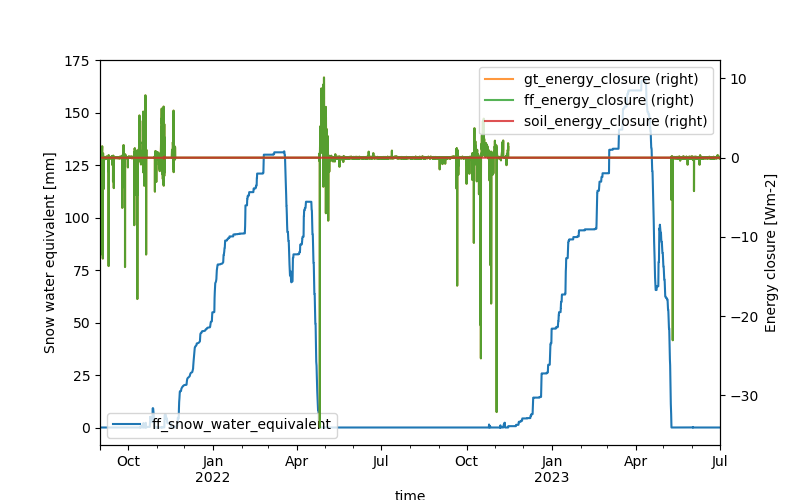

In [ ]:
ax = results_df[
    [
        'ff_snow_water_equivalent',
    ]
].plot(figsize=(8, 5))

# Energy closures on secondary y-axis
ax1 = results_df[
    [
        'gt_energy_closure',
        'ff_energy_closure',
        'soil_energy_closure',
    ]
].plot(
    ax=ax,
    secondary_y=True,
    alpha=0.8
)

ax.legend(loc='lower left')
ax1.legend(loc='upper right')

ax.set_ylabel('Snow water equivalent [mm]')
ax1.set_ylabel('Energy closure [Wm-2]')

filename = f'/Users/jpnousu/Library/CloudStorage/OneDrive-Luonnonvarakeskus/pyAPES_figs/ebal_closure_{snowmod}_2_2026.png'
plt.savefig(filename, dpi=300, bbox_inches="tight")

In [7]:
if snowmod == 'fsm2':

    flux_cols = ['ff_snow_sensible_heat',
                'ff_snow_net_radiation',
                'ff_snow_latent_heat',
                'ff_snow_heat_flux'
    ]

    results_flux = results_df[flux_cols]['2021-10-01':'2022-05-01'].copy()

    results_flux['ff_snow_sensible_heat'] *= -1
    results_flux['ff_snow_latent_heat'] *= -1

    # Daily mean fluxes
    results_flux = results_flux.resample('D').mean()

    results_pos = results_flux.clip(lower=0)
    results_neg = results_flux.clip(upper=0)

    pos = results_pos[flux_cols]  # already daily
    neg = results_neg[flux_cols]  # already daily

    # Ensure identical index for pos/neg
    idx = pos.index.union(neg.index)
    pos = pos.reindex(idx).fillna(0.0)
    neg = neg.reindex(idx).fillna(0.0)

    residual = results_flux.sum(axis=1)

    fig, ax = plt.subplots(figsize=(8, 5))

    x = np.arange(len(idx))
    width = 0.7

    pos_bottom = np.zeros(len(idx))
    neg_bottom = np.zeros(len(idx))

    # Fixed colors per column
    cycle = plt.rcParams['axes.prop_cycle'].by_key().get('color', [])
    colors = {c: cycle[i % len(cycle)] for i, c in enumerate(flux_cols)}

    # Positive stacks
    for col in flux_cols:
        y = pos[col].to_numpy()
        ax.bar(x, y, bottom=pos_bottom, width=width, alpha=0.85, color=colors[col], label=col)
        pos_bottom += y

    # Negative stacks
    for col in flux_cols:
        y = neg[col].to_numpy()
        ax.bar(x, y, bottom=neg_bottom, width=width, alpha=0.85, color=colors[col])
        neg_bottom += y

    ax.plot(
        x,
        residual.reindex(idx).to_numpy(),
        color='black',
        linewidth=1.0,
        linestyle='--',
        label='residual'
    )

    #ax.axhline(0, color="k", linestyle="--", linewidth=0.8)
    ax.set_ylabel("Energy flux [Wm-2]")
    ax.legend(loc="upper left")#, title="Energy fluxes")

    # --- Secondary axis: Snow water equivalent ---
    ax2 = ax.twinx()

    swe = results_df['ff_snow_water_equivalent'].resample('D').mean()
    swe = swe.reindex(idx).interpolate(limit_direction="both")  # or .fillna(0.0)

    ax2.plot(x, swe.to_numpy(), linewidth=1.0, color='black', linestyle='-', label="SWE")
    ax2.set_ylabel("Snow water equivalent [mm]")
    ax2.legend(loc="upper right")

    # Date ticks
    tick_step = max(1, len(idx) // 8)
    ax.set_xticks(x[::tick_step])
    ax.set_xticklabels([d.strftime("%Y-%m-%d") for d in idx[::tick_step]],
                    rotation=30, ha="right")

    plt.tight_layout()
    filename = f'/Users/jpnousu/Library/CloudStorage/OneDrive-Luonnonvarakeskus/pyAPES_figs/ebal_{snowmod}_2_2026.png'
    plt.savefig(filename, dpi=300, bbox_inches="tight")